In [35]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

Task 1

In [36]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data = digits['data']
images = digits['images']
target = digits['target']
target_names = digits['target_names']

print(images.shape) # (1797, 8, 8) 1797 images of 8x8 pixels

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
(1797, 8, 8)


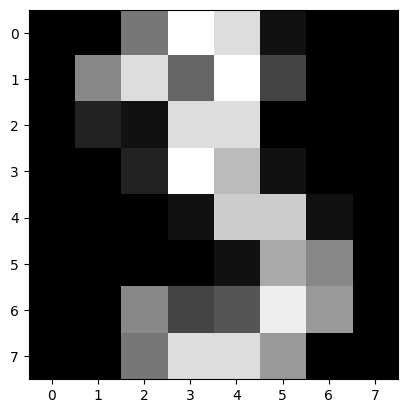

In [37]:
first_three = np.where(target == 3)[0][0]
img = images[first_three]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.show()

In [38]:
from sklearn import model_selection

threes_and_nines = np.logical_or(target == 3, target == 9)
X_all = data[threes_and_nines]
y_all = target[threes_and_nines]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_all, y_all, test_size=0.4, random_state=0)

Task 2

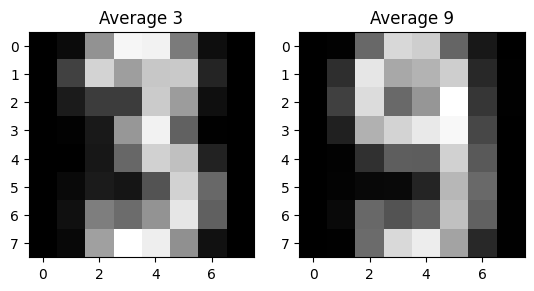

In [39]:
threes = y_train == 3
X_train_three = X_train[threes]
X_train_nine = X_train[~threes]

average_three = np.mean(X_train_three, axis=0)
average_nine = np.mean(X_train_nine, axis=0)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(average_three.reshape(8, 8), cmap='gray', interpolation='nearest')
plt.title('Average 3')
plt.subplot(1, 2, 2)
plt.imshow(average_nine.reshape(8, 8), cmap='gray', interpolation='nearest')
plt.title('Average 9')
plt.show()

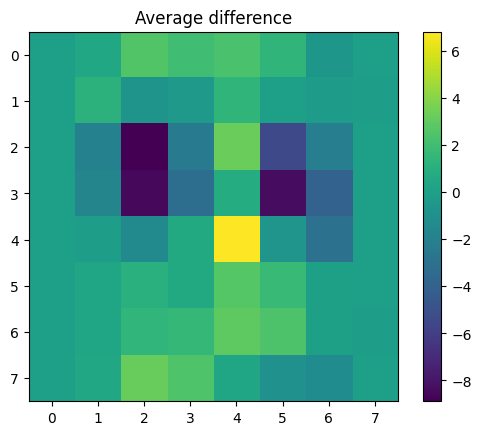

In [40]:
average_diff = average_three - average_nine


plt.figure()
plt.imshow(average_diff.reshape(8, 8), interpolation='nearest')
plt.title('Average difference')
plt.colorbar()
plt.show()

The first feature will be a linear combination of the four most different pixels. 22, 32, 44, 35. This should also give a good indication of whether the image is a 3 or a 9.
The second feature will be a linear combination of some more less important pixels. 25, 24, 72, 64 (written as xy).

In [41]:
def feature2d(X):
    # X has shape (n_samples, n_features) = (n_samples, 64)
    # returns a feature matrix of shape (n_samples, 2)
    X = X / 16.0
    important_pixels = np.zeros(64)
    important_pixels[18], important_pixels[26], important_pixels[29], important_pixels[36] = 1, 1, 1, -1
    feature1 = important_pixels @ X.T
    important_pixels = np.zeros(64)
    important_pixels[20], important_pixels[21], important_pixels[52], important_pixels[58] = 1, -1, 1, 1
    feature2 = important_pixels @ X.T
    return np.array([feature1, feature2]).T

In [42]:
features = feature2d(X_train)

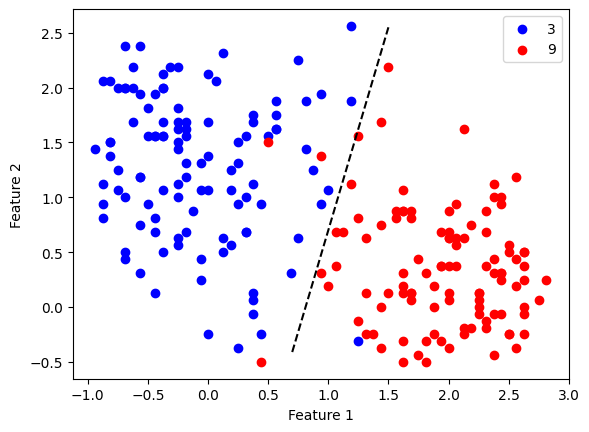

In [43]:
plt.figure()
plt.scatter(features[threes, 0], features[threes, 1], color='b', label='3')
plt.scatter(features[~threes, 0], features[~threes, 1], color='r', label='9')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
X = np.linspace(0.7, 1.5, 100)
Y = X * 3.7 - 3
plt.plot(X, Y, 'k--')
plt.show()

The first feature is very informative, the second feature is less informative but still useful.
Striped line is a possible decision boundary with $\beta = 3.7$ and $b = -3$

In [44]:
def nearest_mean(training_features, training_labels, test_features):
    # training_features has shape (n_samples, 2)
    # training_labels has shape (n_samples,)
    # test_features has shape (n_samples, 2)
    # returns an array of shape (n_samples,) with predicted labels
    threes = training_features[training_labels == 3]
    nines = training_features[training_labels == 9]
    threes_mean = np.mean(threes, axis=0)
    nines_mean = np.mean(nines, axis=0)
    distance_to_threes = np.linalg.norm(test_features - threes_mean, axis=1)
    distance_to_nines = np.linalg.norm(test_features - nines_mean, axis=1)
    return np.where(distance_to_threes < distance_to_nines, 1, -1)

def decision_boundary(test_features):
    beta = 3.7
    b = -3
    y = beta * test_features[:, 0] + b - test_features[:, 1]
    return -np.sign(y) # flip sign to match the sign of the labels

In [45]:
predicted_labels1 = nearest_mean(feature2d(X_train), y_train, feature2d(X_test))
predicted_labels2 = decision_boundary(feature2d(X_test))
correct_labels = np.where(y_test == 3, 1, -1)

accuracy1 = np.mean(predicted_labels1 == correct_labels)
accuracy2 = np.mean(predicted_labels2 == correct_labels)
amount1 = np.sum(predicted_labels1 == correct_labels)
amount2 = np.sum(predicted_labels2 == correct_labels)
print(amount1, amount2)
print(accuracy1, accuracy2)

142 144
0.9726027397260274 0.9863013698630136


Both custom features have good performance, the custom decision boundary is a bit better.

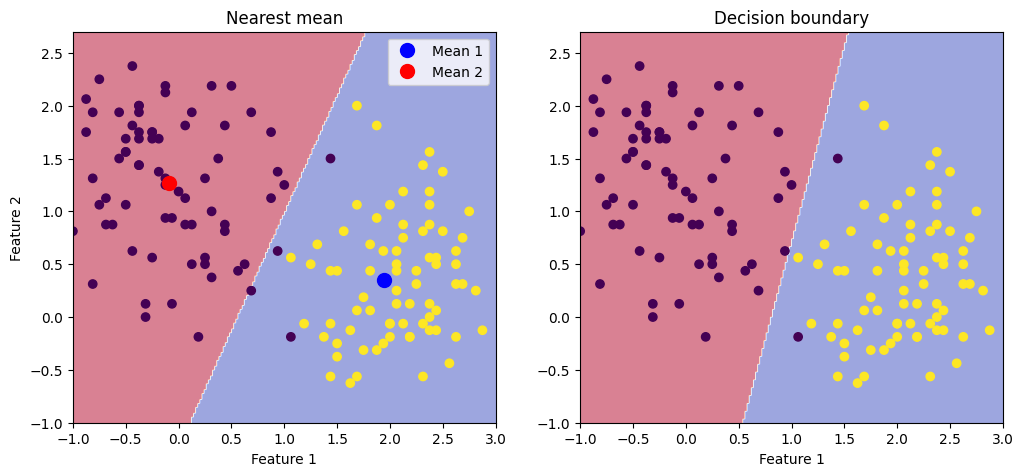

In [46]:
dimension_1 = np.linspace(-1, 3, 200)
dimension_2 = np.linspace(-1, 2.7, 200)
D1, D2 = np.meshgrid(dimension_1, dimension_2)
features = np.array([D1.flatten(), D2.flatten()]).T
predicted_labels1 = nearest_mean(feature2d(X_train), y_train, features).reshape(200, 200)
predicted_labels2 = decision_boundary(features).reshape(200, 200)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(predicted_labels1, extent=(-1, 3, -1, 2.7), origin='lower', cmap='coolwarm', alpha=0.5)
ax[0].scatter(feature2d(X_test)[:, 0], feature2d(X_test)[:, 1], c=y_test)
ax[0].plot(1.94, 0.35, 'o', label='Mean 1', color='b', markersize=10)
ax[0].plot(-0.094, 1.27, 'o', label='Mean 2', color='r', markersize=10)
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
ax[0].set_title('Nearest mean')
ax[0].legend()
ax[1].imshow(predicted_labels2, extent=(-1, 3, -1, 2.7), origin='lower', cmap='coolwarm', alpha=0.5)
ax[1].scatter(feature2d(X_test)[:, 0], feature2d(X_test)[:, 1], c=y_test)
ax[1].set_xlabel('Feature 1')
ax[1].set_title('Decision boundary')

plt.show()



both decision boundaries are similar, but the custom one is a bit better.

Testing with custom 3 image.

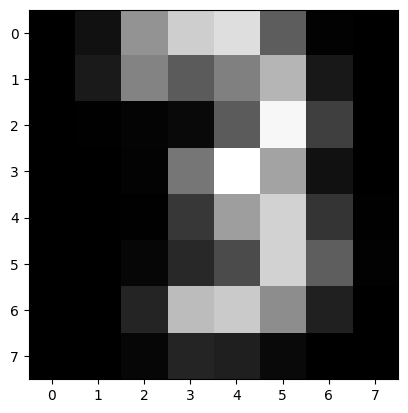

In [47]:
# not required for the assignment, so feel free to skip these two cells

import matplotlib.image as mpimg
img = mpimg.imread('3.png')
img = 1 - img[:, :, 0]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.show()

In [48]:
img = img.flatten()
img = img.reshape(1, -1)
is_three_decision_boundary = decision_boundary(feature2d(img))[0] == 1
is_three_nearest_mean = nearest_mean(feature2d(X_train), y_train, feature2d(img))[0] == 1
print(is_three_decision_boundary, is_three_nearest_mean)

True True


Task 3.1

In [49]:
def fit_lda(training_features, training_labels):
    # training_features has shape (N, D)
    # training_labels has shape (N)
    # two classes are assumed
    # labels are assumed to be 1 and -1
    # returns:
    # mu: mean of the data, shape (2, D)
    # covmat: covariance matrix, shape (D, D)
    # p: prior probability of both classes, shape (2)
    pos = training_features[training_labels == 1]
    neg = training_features[training_labels == -1]
    mu = np.array([np.mean(pos, axis=0), np.mean(neg, axis=0)])
    covmat = np.cov(training_features.T)
    # covmat = 1 / len(training_features) * (np.sum((training_features - mu[0]) @ (training_features - mu[0]), axis=0) + np.sum((training_features - mu[1]) @ (training_features - mu[1]), axis=0))
    p = np.array([len(pos) / len(training_labels), len(neg) / len(training_labels)])
    return mu, covmat, p

In [50]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_all, y_all, test_size=0.4, random_state=0)

X_features_2d = feature2d(X_train)
labels = np.where(y_train == 3, 1, -1)
dead_pixels = np.var(X_train, axis=0) < 0.001
X_train_filtered = X_train[:, ~dead_pixels]
mu0, covmat0, p0 = fit_lda(X_train_filtered, labels)
mu1, covmat1, p1 = fit_lda(X_features_2d, labels)

Task 3.2

In [51]:
def predict_lda(mu, covmat, p, test_features):
    # mu has shape (2, D)
    # covmat has shape (D, D)
    # p has shape (2)
    # test_features has shape (M, D)
    # returns an array of shape (M) with predicted labels
    inv_covmat = np.linalg.inv(covmat)
    beta = inv_covmat @ (mu[0] - mu[1])
    b = -0.5 * (mu[0] + mu[1]) @ beta + np.log(p[0] / p[1])
    y = test_features @ beta + b
    return np.sign(y)


In [52]:
predicted_labels0 = predict_lda(mu0, covmat0, p0, X_test[:, ~dead_pixels])
predicted_labels1 = predict_lda(mu1, covmat1, p1, feature2d(X_test))
train_labels = np.where(y_test == 3, 1, -1)

accuracy0 = np.mean(predicted_labels0 == train_labels)
accuracy1 = np.mean(predicted_labels1 == train_labels)

predicted_labels_train0 = predict_lda(mu0, covmat0, p0, X_train[:, ~dead_pixels])
predicted_labels_train1 = predict_lda(mu1, covmat1, p1, feature2d(X_train))
train_labels = np.where(y_train == 3, 1, -1)

accuracy_train0 = np.mean(predicted_labels_train0 == train_labels)
accuracy_train1 = np.mean(predicted_labels_train1 == train_labels)

In [53]:
print(f"Whole image training accuracy: {accuracy0*100:.1f}%, test accuracy: {accuracy1*100:.1f}%\n"
    f"Feature 2D training accuracy: {accuracy_train0*100:.1f}%, test accuracy: {accuracy_train1*100:.1f}%")

Whole image training accuracy: 98.6%, test accuracy: 97.9%
Feature 2D training accuracy: 99.5%, test accuracy: 97.7%


In [54]:
# printing with pandas, skip if you don't have it installed
import pandas as pd
df = pd.DataFrame({'Method': ['Image', 'Feature 2D'],
                   'Train accuracy': [accuracy_train0, accuracy_train1],
                   'Test accuracy': [accuracy0, accuracy1]})
print(df.to_string(index=False, formatters={'Train accuracy': '{:.1%}'.format, 'Test accuracy': '{:.1%}'.format}))

    Method Train accuracy Test accuracy
     Image          99.5%         98.6%
Feature 2D          97.7%         97.9%


In [55]:
dimension_1 = np.linspace(-1, 3, 200)
dimension_2 = np.linspace(-0.5, 2.7, 200)
D1, D2 = np.meshgrid(dimension_1, dimension_2)
features = np.array([D1.flatten(), D2.flatten()]).T
predicted_labels = predict_lda(mu1, covmat1, p1, features).reshape(200, 200)


In [56]:
def gaussian(x, mu, covmat):
    inv_covmat = np.linalg.inv(covmat)
    D = x - mu
    return np.exp(-0.5 * np.sum(D @ inv_covmat * D, axis=1))

gaus1 = gaussian(features, mu1[0], covmat1)
gaus2 = gaussian(features, mu1[1], covmat1)

In [57]:
e, v = np.linalg.eig(covmat1)
sd = np.sqrt(e)
cluster_means = mu1
vector_1 = v[:, 0] * sd[0]
vector_2 = v[:, 1] * sd[1]


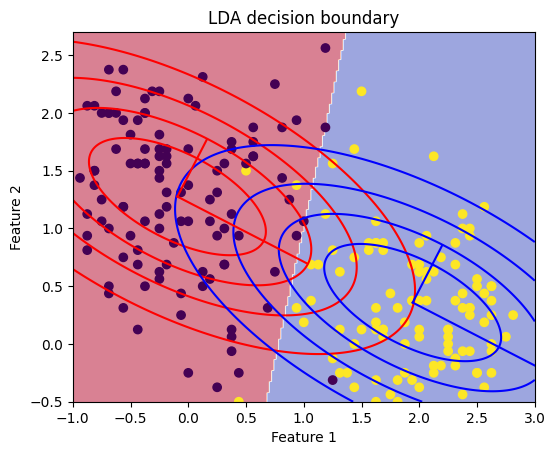

In [58]:
plt.imshow(predicted_labels, extent=(-1, 3, -0.5, 2.7), origin='lower', cmap='coolwarm', alpha=0.5)
plt.xlim(-1, 3)
plt.ylim(-0.5, 2.7)
plt.scatter(feature2d(X_train)[:, 0], feature2d(X_train)[:, 1], c=y_train)
plt.contour(D1, D2, gaus1.reshape(200, 200), levels=5, colors='r')
plt.contour(D1, D2, gaus2.reshape(200, 200), levels=5, colors='b')
plt.plot([cluster_means[0, 0], cluster_means[0, 0] + vector_1[0]], [cluster_means[0, 1], cluster_means[0, 1] + vector_1[1]], 'r')
plt.plot([cluster_means[0, 0], cluster_means[0, 0] + vector_2[0]], [cluster_means[0, 1], cluster_means[0, 1] + vector_2[1]], 'r')
plt.plot([cluster_means[1, 0], cluster_means[1, 0] + vector_1[0]], [cluster_means[1, 1], cluster_means[1, 1] + vector_1[1]], 'b')
plt.plot([cluster_means[1, 0], cluster_means[1, 0] + vector_2[0]], [cluster_means[1, 1], cluster_means[1, 1] + vector_2[1]], 'b')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('LDA decision boundary')
plt.show()

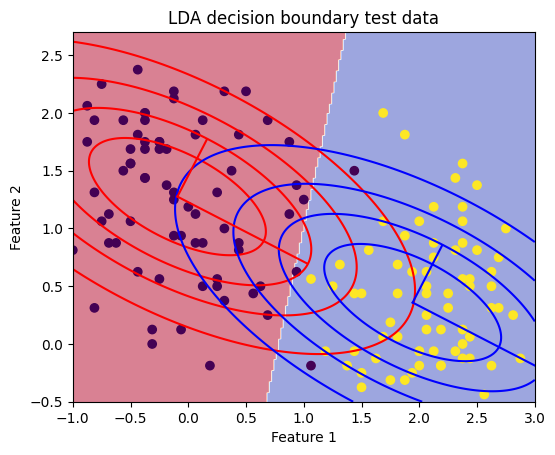

In [59]:
plt.imshow(predicted_labels, extent=(-1, 3, -0.5, 2.7), origin='lower', cmap='coolwarm', alpha=0.5)
plt.xlim(-1, 3)
plt.ylim(-0.5, 2.7)
plt.scatter(feature2d(X_test)[:, 0], feature2d(X_test)[:, 1], c=y_test)
plt.contour(D1, D2, gaus1.reshape(200, 200), levels=5, colors='r')
plt.contour(D1, D2, gaus2.reshape(200, 200), levels=5, colors='b')
plt.plot([cluster_means[0, 0], cluster_means[0, 0] + vector_1[0]], [cluster_means[0, 1], cluster_means[0, 1] + vector_1[1]], 'r')
plt.plot([cluster_means[0, 0], cluster_means[0, 0] + vector_2[0]], [cluster_means[0, 1], cluster_means[0, 1] + vector_2[1]], 'r')
plt.plot([cluster_means[1, 0], cluster_means[1, 0] + vector_1[0]], [cluster_means[1, 1], cluster_means[1, 1] + vector_1[1]], 'b')
plt.plot([cluster_means[1, 0], cluster_means[1, 0] + vector_2[0]], [cluster_means[1, 1], cluster_means[1, 1] + vector_2[1]], 'b')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('LDA decision boundary test data')
plt.show()

The quality of the LDA for both training and testing is good.

Task 3.4, cross-validation

In [60]:
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

kf = KFold(n_splits=10, shuffle=True, random_state=0)
accuracies_custom = []
accuracies_sklearn = []

labels = np.where(y_all == 3, 1, -1)
for test, train in kf.split(X_all):
    X_test, X_train = X_all[test], X_all[train]
    y_test, y_train = labels[test], labels[train]
    X_features_2d = feature2d(X_train)
    mu, covmat, p = fit_lda(X_features_2d, y_train)
    predicted_label = predict_lda(mu1, covmat1, p1, feature2d(X_test))

    lda = LinearDiscriminantAnalysis()
    lda.fit(X_features_2d, y_train)
    predicted_label_sklearn = lda.predict(feature2d(X_test))
    
    accuracy_custom = np.mean(predicted_label == y_test)
    accuracies_custom.append(accuracy_custom)

    accuracy_sklearn = np.mean(predicted_label_sklearn == y_test)
    accuracies_sklearn.append(accuracy_sklearn)

print(f"My implementation accuracy: {np.mean(accuracies_custom)*100:.1f}% +- {np.std(accuracies_custom)*100:.1f}%")
print(f"SKLearn accuracy: {np.mean(accuracies_sklearn)*100:.1f}% +- {np.std(accuracies_sklearn)*100:.1f}%")

My implementation accuracy: 97.8% +- 0.3%
SKLearn accuracy: 97.5% +- 1.1%


Task 4 SVM

In [61]:
def predict_svm(beta, b, test_features):
    # beta has shape (D)
    # b has shape (1)
    # test_features has shape (M, D)
    # returns an array of shape (M) with predicted labels
    return np.sign(test_features @ beta + b)

def fit_svm(training_features, training_labels, lam, T = 1000, return_all=False):
    # training_features has shape (N, D)
    # training_labels has shape (N)
    # labels are assumed to be 1 and -1
    # lam is the hyperparameter
    # returns:
    # beta: weights has shape (D)
    # b: bias has shape (1)
    N, D = training_features.shape
    beta = np.random.normal(size=D)
    b = 0
    lr = 0.1

    def diff_beta(beta, training_features, training_labels, mask):
        return lam * beta + np.sum(-training_features[mask] * training_labels[mask, None], axis=0) * lam / N
    
    def diff_b(training_labels, mask):
        return np.sum(-training_labels[mask]) * lam / N
    
    def training_error(beta, b, training_features, training_labels):
        predicted = predict_svm(beta, b, training_features)
        return np.mean(np.maximum(0, 1 - training_labels * predicted))

    def loss(beta, b, training_features, training_labels):
        first = 0.5 * beta @ beta
        second = lam / N * np.sum(np.maximum(0, 1 - training_labels * (training_features @ beta + b)))
        return first + second
    
    def is_stagnating(errors, lr):
        if len(errors) < 5:
            return False
        return np.all(np.abs(np.diff(errors[-10:])) < lr * 1e-5)
    
    training_errors = []
    losses = []
    lrs = []
    
    for _ in range(T):
        y = training_features @ beta + b
        margin = training_labels * y
        mask = margin < 1
        beta -= lr * diff_beta(beta, training_features, training_labels, mask)
        b -= lr * diff_b(training_labels, mask)

        training_errors.append(training_error(beta, b, training_features, training_labels))
        losses.append(loss(beta, b, training_features, training_labels))
        lrs.append(lr)
        if is_stagnating(training_errors, lr):
            lr = lr * 0.1
        
        if lr < 1e-6:
            break
    
    if return_all:
        return beta, b, training_errors, losses, lrs
    return beta, b

In [62]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_all, y_all, test_size=0.4, random_state=0)
X_features_2d = feature2d(X_train)
labels = np.where(y_train == 3, 1, -1)
beta, b, errors, losses, lrs = fit_svm(X_features_2d, labels, 0.5, return_all=True)
predicted_labels = predict_svm(beta, b, feature2d(X_test))
test_labels = np.where(y_test == 3, 1, -1)
accuracy = np.mean(predicted_labels == test_labels)

In [63]:
accuracy

0.952054794520548

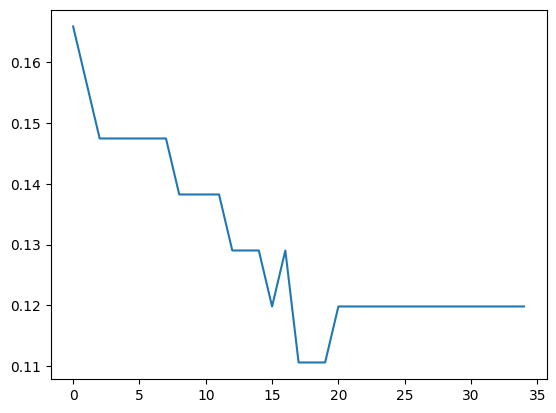

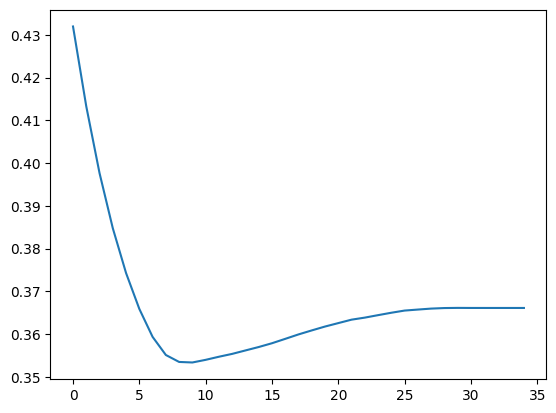

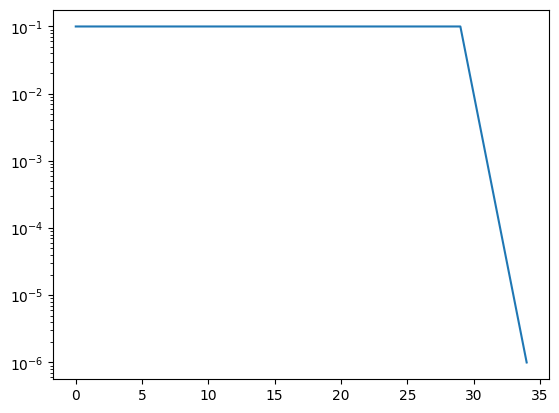

In [64]:
plt.plot(errors)
plt.show()

plt.plot(losses)
plt.show()

plt.plot(lrs)
plt.yscale('log')
plt.show()

In [65]:
dimension_1 = np.linspace(-1, 3, 200)
dimension_2 = np.linspace(-0.5, 2.7, 200)
D1, D2 = np.meshgrid(dimension_1, dimension_2)
features = np.array([D1.flatten(), D2.flatten()]).T
predicted_labels = predict_svm(beta, b, features).reshape(200, 200)

In [66]:
X = np.linspace(-1, 3, 100)
Y = -beta[0] / beta[1] * X - b / beta[1]

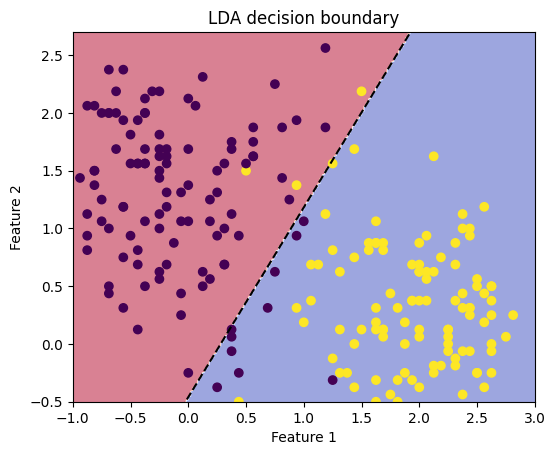

In [67]:
plt.imshow(predicted_labels, extent=(-1, 3, -0.5, 2.7), origin='lower', cmap='coolwarm', alpha=0.5)
plt.xlim(-1, 3)
plt.ylim(-0.5, 2.7)
plt.scatter(feature2d(X_train)[:, 0], feature2d(X_train)[:, 1], c=y_train)
plt.plot(X, Y, 'k--')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('LDA decision boundary')
plt.show()

In [68]:
from sklearn.svm import SVC

lambdas = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1,2,3,4,5,10]
kf = KFold(n_splits=10, shuffle=True, random_state=0)
accuracies_custom = []
accuracies_sklearn = []

digits = load_digits()
threes_and_nines = np.logical_or(target == 3, target == 9)
X_all = digits['data'][threes_and_nines]
y_all = digits['target'][threes_and_nines]
labels = np.where(y_all == 3, 1, -1)
X_features = feature2d(X_all)

for lam in lambdas:
    for test, train in kf.split(X_features):
        X_test, X_train = X_features[test], X_features[train]
        y_test, y_train = labels[test], labels[train]

        beta, b = fit_svm(X_train, y_train, lam)
        predicted_label = predict_svm(beta, b, X_test)

        svm = SVC(C=lam)
        svm.fit(X_train, y_train)
        predicted_label_sklearn = svm.predict(X_test)
        
        accuracy_custom = np.mean(predicted_label == y_test)
        accuracies_custom.append(accuracy_custom)

        accuracy_sklearn = np.mean(predicted_label_sklearn == y_test)
        accuracies_sklearn.append(accuracy_sklearn)

    print(f"Lambda: {lam:.2f}, My implementation accuracy: {np.mean(accuracies_custom)*100:.1f}% +- {np.std(accuracies_custom)*100:.1f}%")
    print(f"Lambda: {lam:.2f}, SKLearn accuracy: {np.mean(accuracies_sklearn)*100:.1f}% +- {np.std(accuracies_sklearn)*100:.1f}%")

Lambda: 0.01, My implementation accuracy: 47.1% +- 32.4%
Lambda: 0.01, SKLearn accuracy: 48.9% +- 0.6%
Lambda: 0.02, My implementation accuracy: 54.3% +- 27.0%
Lambda: 0.02, SKLearn accuracy: 48.9% +- 0.6%
Lambda: 0.05, My implementation accuracy: 52.8% +- 28.2%
Lambda: 0.05, SKLearn accuracy: 51.8% +- 9.0%
Lambda: 0.10, My implementation accuracy: 54.6% +- 27.2%
Lambda: 0.10, SKLearn accuracy: 61.4% +- 19.8%
Lambda: 0.20, My implementation accuracy: 53.4% +- 29.8%
Lambda: 0.20, SKLearn accuracy: 68.4% +- 22.6%
Lambda: 0.50, My implementation accuracy: 58.0% +- 30.2%
Lambda: 0.50, SKLearn accuracy: 73.1% +- 23.2%
Lambda: 0.60, My implementation accuracy: 62.5% +- 30.3%
Lambda: 0.60, SKLearn accuracy: 76.5% +- 23.0%
Lambda: 0.70, My implementation accuracy: 64.5% +- 29.8%
Lambda: 0.70, SKLearn accuracy: 79.0% +- 22.5%
Lambda: 0.80, My implementation accuracy: 67.6% +- 29.5%
Lambda: 0.80, SKLearn accuracy: 81.0% +- 22.0%
Lambda: 0.90, My implementation accuracy: 69.2% +- 28.9%
Lambda: 0.

lambda = 5 seems to be the best value for my SVM.
My SVM is noticeably worse than the one from sklearn (has a higher sd and lower mean accuracy), probably because of an inoptimal learning rate schedule.
But both mine and sklearn's have a way bigger sd than the LDA and nearest mean classifier.